In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
import os
import pandas as pd
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.animation as animation
import torch
from IPython.display import HTML
from IPython.display import HTML


In [2]:
file_path = './data/meps_example/samples/train/nwp_2022040100_mbr000.npy'  # Đổi 'duong_dan_toi_file.npy' thành đường dẫn thực tế của bạn
data = np.load(file_path)
print(data.shape)
print()

(65, 268, 238, 18)



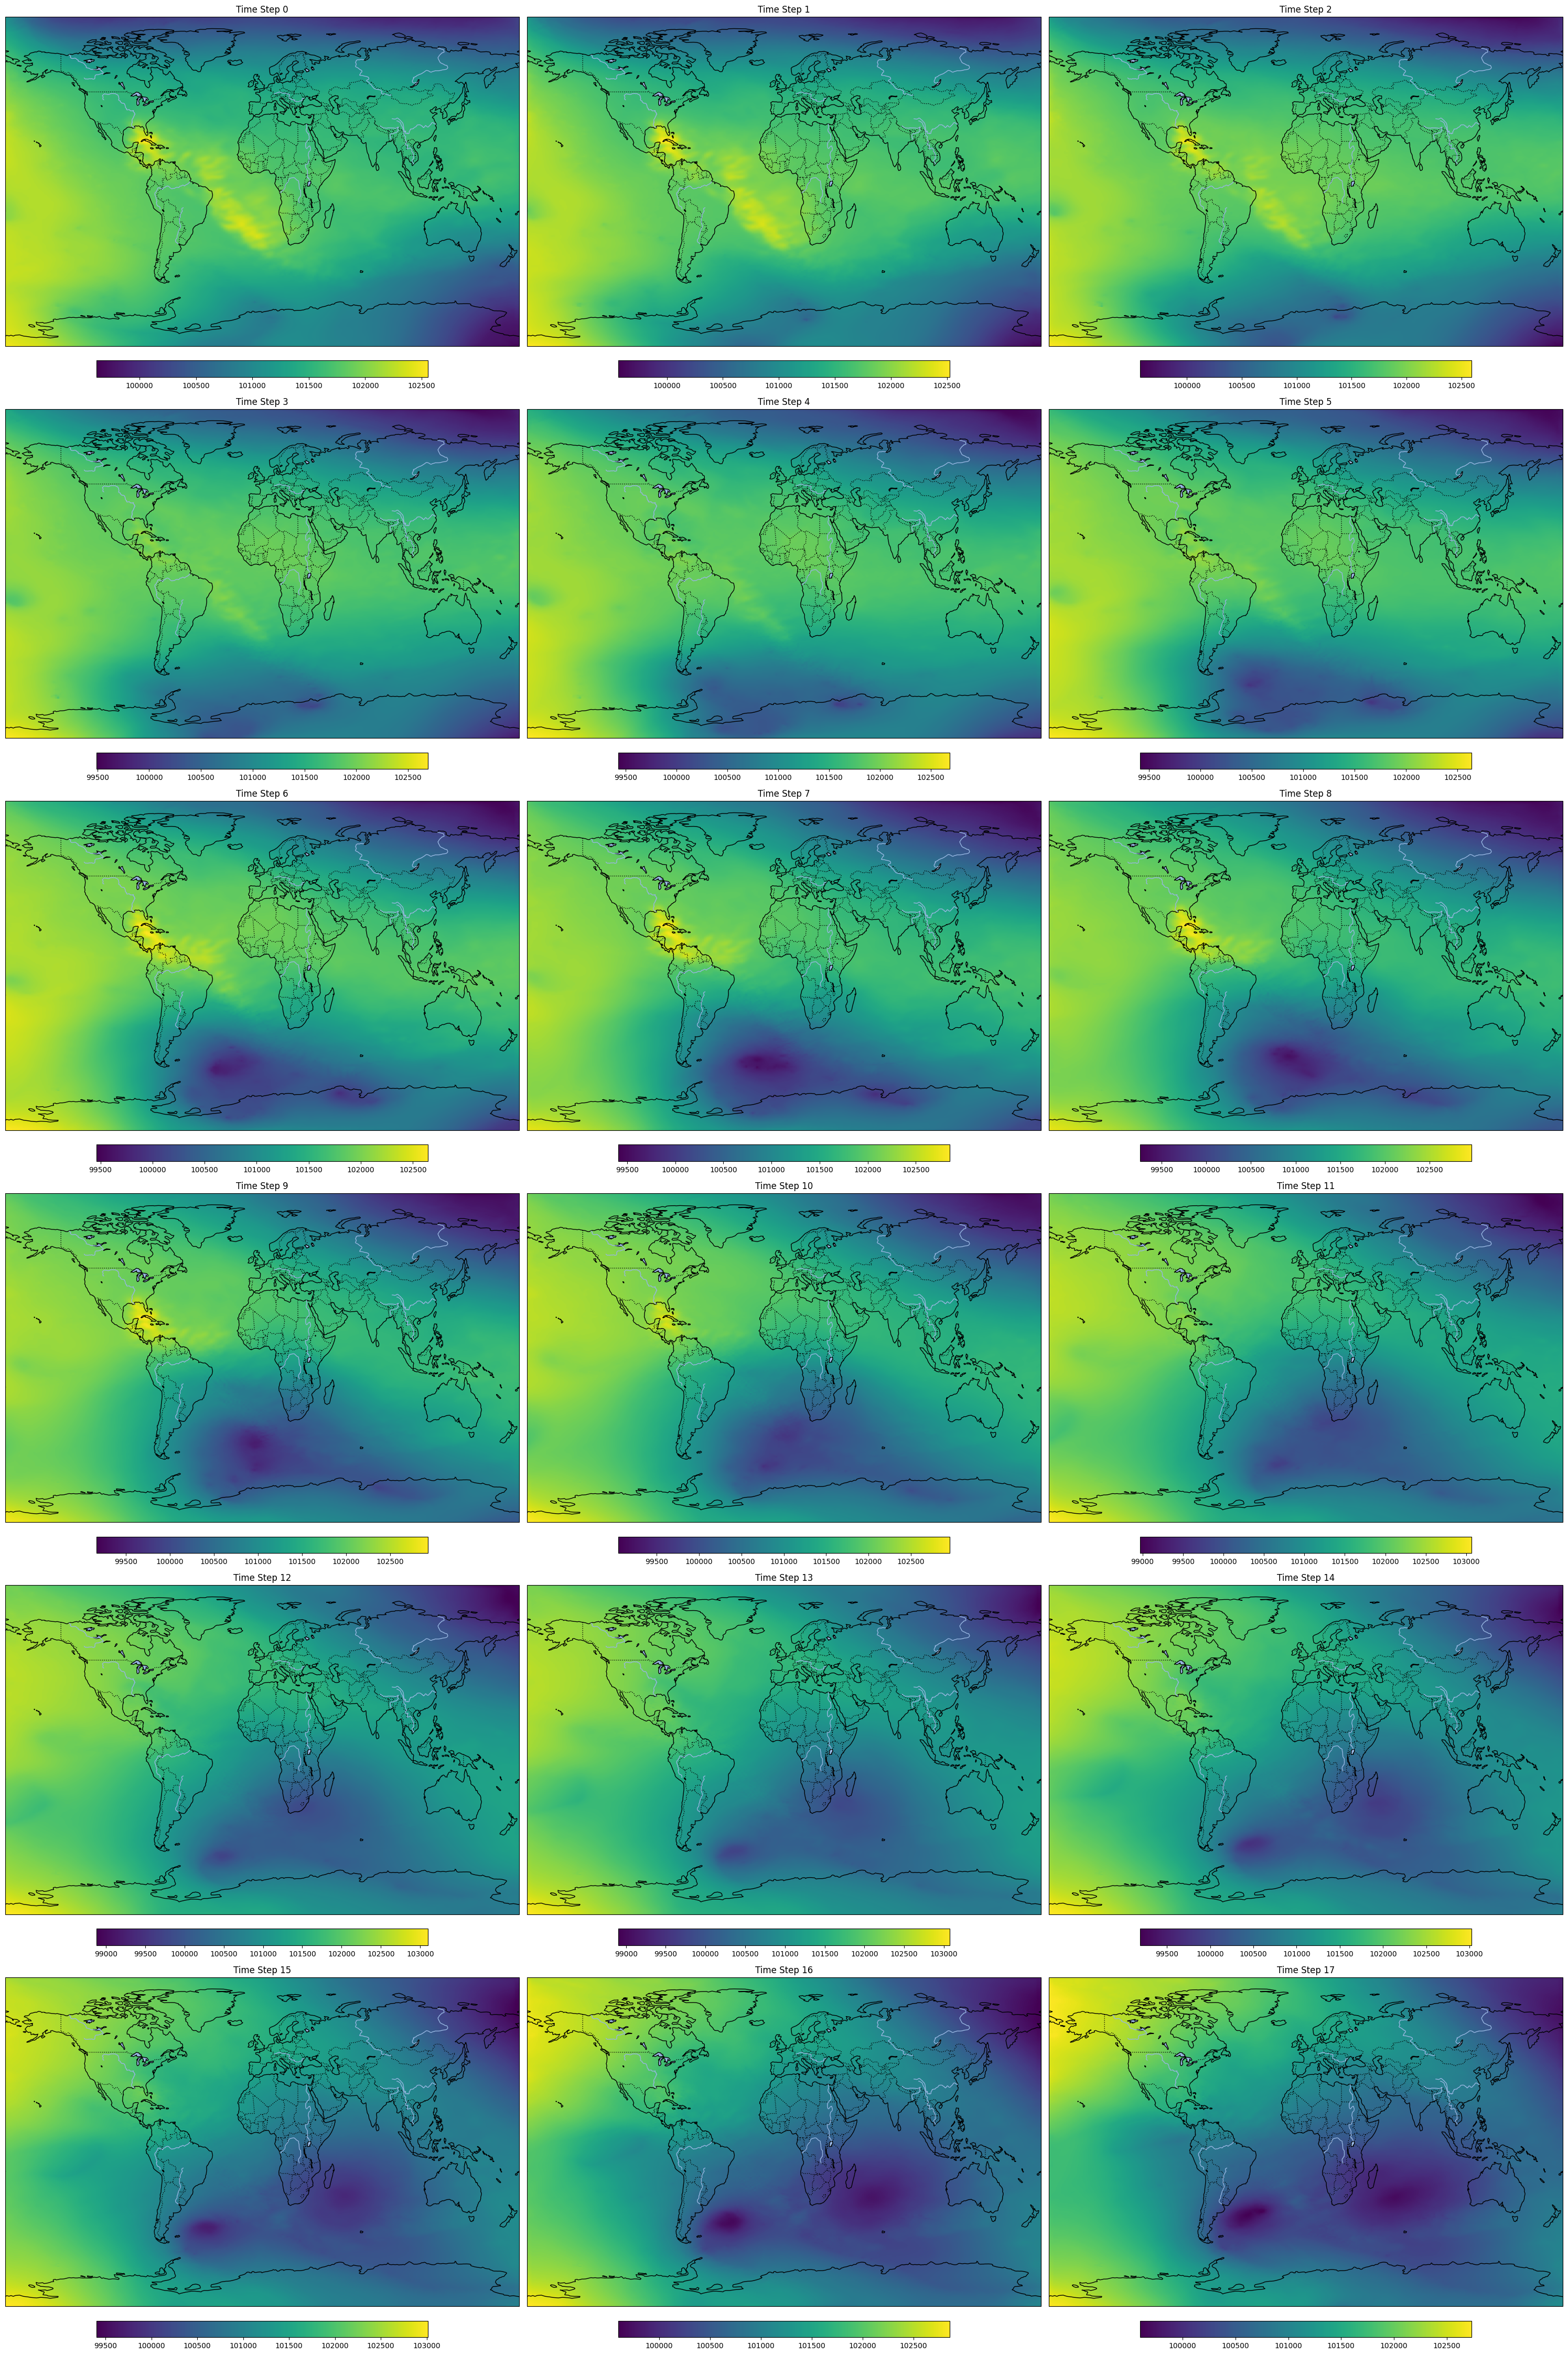

In [11]:
selected_variable = data[:, :, :, 1]

# Create a grid of subplots (6 rows x 3 columns for 18 maps total)
fig, axes = plt.subplots(nrows=6, ncols=3, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(30, 45))
axes = axes.flatten()

# Loop through all 65 time steps, but for simplicity, show 18 time steps
for i in range(18):
    ax = axes[i]
    
    # Add map features
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='black')
    ax.add_feature(cfeature.LAKES, edgecolor='black')
    ax.add_feature(cfeature.RIVERS)
    ax.add_feature(cfeature.OCEAN)
    
    # Plot the heatmap for the selected weather variable at time step `i`
    im = ax.imshow(selected_variable[3*i, :, :], cmap='viridis', extent=[-180, 180, -90, 90], transform=ccrs.PlateCarree(), aspect='auto')
    
    # Add a colorbar to show the scale of values
    plt.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
    
    # Set title for each subplot
    ax.set_title(f'Time Step {i}')

plt.tight_layout()
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


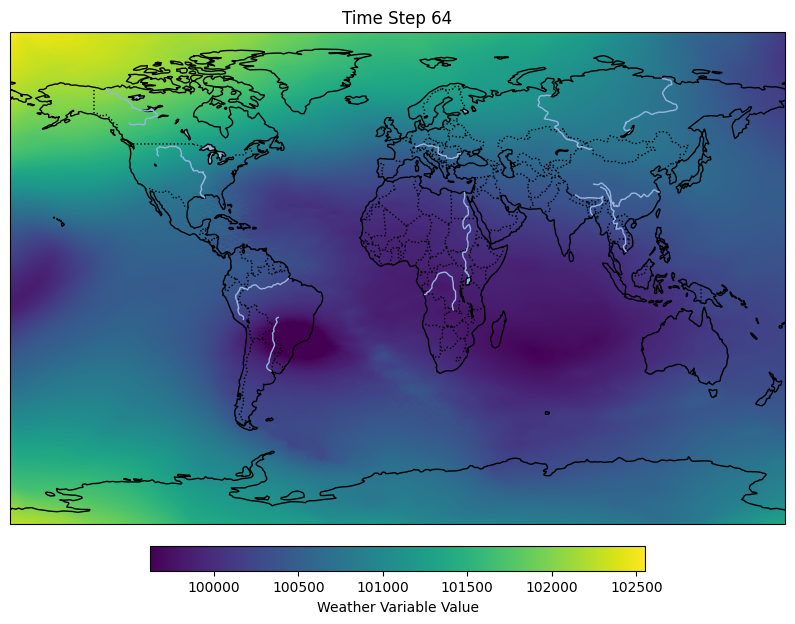

In [13]:

# Assuming 'data' is your array with shape (65, 268, 238, 18)
# Select one weather variable, for example, the first one (index 0)
selected_variable = data[:, :, :, 1]

# Create a figure and an axis with Cartopy projection
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})

# Add static map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.OCEAN)

# Function to initialize the first frame
def init():
    im.set_data(np.zeros((268, 238)))  # Initialize with a blank frame
    return [im]

# Function to update the animation with each time step
def update(t):
    ax.set_title(f'Time Step {t}')
    im.set_data(selected_variable[t, :, :])
    return [im]

# Create the heatmap plot (initial frame)
im = ax.imshow(selected_variable[0, :, :], cmap='viridis', extent=[-180, 180, -90, 90], transform=ccrs.PlateCarree(), aspect='auto')

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Weather Variable Value')

# Create the animation
ani = FuncAnimation(fig, update, frames=range(65), init_func=init, blit=True, interval=200)

# Save the animation as a GIF or MP4 video file
ani.save('weather_animation.gif', writer='imagemagick')  # Save as GIF
# ani.save('weather_animation.mp4', writer='ffmpeg')  # Save as MP4

plt.show()


In [130]:
import os
from datetime import timedelta, datetime

# Tạo các thư mục train, val, test nếu chưa tồn tại
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
# Đường dẫn đến các thư mục
rainfall_folder = 'dataprin/meps_example/samples'  # Thư mục chứa các file .npy
train_folder = os.path.join(rainfall_folder, 'train')
val_folder = os.path.join(rainfall_folder, 'val')
test_folder = os.path.join(rainfall_folder, 'test')

# Tạo các thư mục train, val, test nếu chưa tồn tại
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Danh sách các file rainfall theo từng tháng (01 đến 12)
rainfall_files = [f"rainfall_NW_2018_{str(i).zfill(2)}.npy" for i in range(1, 13)]

# Tỷ lệ chia dữ liệu
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Số bước thời gian mỗi file sẽ chứa
time_steps_per_day = 288  # Có 288 bước thời gian mỗi ngày (5 phút một bước)

# Duyệt qua từng file rainfall và xử lý
for month_idx, file_name in enumerate(rainfall_files):
    file_path = os.path.join(rainfall_folder, file_name)  # Đường dẫn đầy đủ đến file .npy
    
    # Kiểm tra nếu file tồn tại
    if os.path.exists(file_path):
        # Đọc dữ liệu từ file
        data = np.load(file_path)
        
        # Lấy kích thước dữ liệu
        num_samples = data.shape[0]  # Số bước thời gian trong dữ liệu
        start_date = datetime(2018, month_idx + 1, 1)  # Ngày bắt đầu cho tháng này

        # Chia dữ liệu theo tỷ lệ train, val, test
        train_end = int(num_samples * train_ratio)
        val_end = train_end + int(num_samples * val_ratio)

        # Dữ liệu train: 70% đầu tiên
        train_data = data[:train_end]
        # Dữ liệu val: 15% tiếp theo
        val_data = data[train_end:val_end]
        # Dữ liệu test: phần còn lại
        test_data = data[val_end:]

        # Hàm lưu dữ liệu theo từng ngày
        def save_by_day(data_split, folder, split_type, start_date):
            num_time_steps = data_split.shape[0]
            num_days = (num_time_steps + time_steps_per_day - 1) // time_steps_per_day  # Tính số ngày
            current_date = start_date

            for i in range(num_days):
                start_idx = i * time_steps_per_day
                end_idx = min(start_idx + time_steps_per_day, num_time_steps)
                file_data = data_split[start_idx:end_idx]  # Dữ liệu của một ngày

                # Tạo tên file theo định dạng nwp_2018mmdd.npy
                date_str = current_date.strftime('%Y%m%d')
                np.save(os.path.join(folder, f'nwp_{date_str}.npy'), file_data)
                
                # Chuyển sang ngày tiếp theo
                current_date += timedelta(days=1)

        # Lưu dữ liệu train theo ngày
        save_by_day(train_data, train_folder, 'train', start_date)
        
        # Lưu dữ liệu val theo ngày
        save_by_day(val_data, val_folder, 'val', start_date + timedelta(days=len(train_data) // time_steps_per_day))
        
        # Lưu dữ liệu test theo ngày
        save_by_day(test_data, test_folder, 'test', start_date + timedelta(days=(len(train_data) + len(val_data)) // time_steps_per_day))

    else:
        print(f"File not found: {file_path}")

print("Data has been split and saved into train, val, and test folders.")


Data has been split and saved into train, val, and test folders.
